# NYC taxi trip duration

Jingyi Wang, jw3507. Jingyi Wang, jw3665. Meng Ren, mr3847. Hong Chen, hc3028.

## Bonus

<font color ='blue'>
    
    
The address for our website is: http://hc3028.pythonanywhere.com/
***

## Import Libaries

In [19]:
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
import numpy as np
import seaborn as sns
import math
import time

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV, KFold, RandomizedSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb
from scipy.stats import uniform, randint
import pickle

from google.cloud import bigquery

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore") #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.max_columns', 500)
# os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='My First Project-637ed6c657f0.json'
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]='My Project 64317-280a235315bd.json'

## Import Data

Query and join data, compute travel duration and euclidian distance

In [2]:
client = bigquery.Client()


query = (
    """
    CREATE TEMPORARY FUNCTION euclidian_dist( x_long FLOAT64 , y_long FLOAT64 , x_lat FLOAT64, y_lat FLOAT64) AS (SQRT(POW((x_long - y_long),2) + POW(( x_lat - y_lat), 2)));
    
    SELECT * FROM 
    (
    SELECT *,
    DATETIME_DIFF( dropoff_datetime, pickup_datetime, SECOND) as travel_time,
     euclidian_dist(pickup_longitude,dropoff_longitude,pickup_latitude,dropoff_latitude) as euclidian_dist ,
     
     EXTRACT (HOUR FROM pickup_datetime) as hour_of_day,
     EXTRACT (DATE FROM pickup_datetime) as date_of_year,
     EXTRACT (DAY FROM pickup_datetime) as day_of_year,
     EXTRACT (MONTH FROM pickup_datetime) as month_of_year,
     EXTRACT (YEAR FROM pickup_datetime) as year_of_year
    
    FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016` ) a 
    INNER JOIN
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) weather_data
    on CAST(a.date_of_year AS STRING)=weather_data.date_of_year2 WHERE CAST(year_of_year AS STRING)='2016'
    LIMIT 1000000"""
)
df1=pd.io.gbq.read_gbq(query,dialect='standard')

In [3]:
df=df1
df

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,euclidian_dist,hour_of_day,date_of_year,day_of_year,month_of_year,year_of_year,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder
0,1,2016-05-16 20:35:35,2016-05-16 20:45:59,1,1.80,0.000000,0.000000,1,N,0.000000,0.000000,1,9.5,0.5,0.5,2.15,0.00,0.3,12.95,624,0.000000,20,2016-05-16,16,5,2016,2016-05-16,2016,05,16,52.5,999.9,999.9,999.9,66.2,42.8,0.00,999.9,0,0,0,0,0
1,1,2016-08-24 17:27:52,2016-08-24 17:44:34,1,2.10,NaN,NaN,1,N,NaN,NaN,1,12.0,1.0,0.5,2.75,0.00,0.3,16.55,1002,NaN,17,2016-08-24,24,8,2016,2016-08-24,2016,08,24,76.9,9.4,2.1,999.9,87.8,68.0,0.00,999.9,0,0,0,0,0
2,2,2016-01-08 10:09:04,2016-01-08 10:14:58,5,1.24,-73.977608,40.763653,1,N,-73.962196,40.770412,2,6.0,0.0,0.5,0.00,0.00,0.3,6.80,354,0.016829,10,2016-01-08,8,1,2016,2016-01-08,2016,01,08,40.2,10.0,4.3,999.9,44.6,35.6,0.00,999.9,0,0,0,0,0
3,2,2016-12-20 13:02:10,2016-12-20 13:13:12,1,1.69,NaN,NaN,1,N,NaN,NaN,1,9.0,0.0,0.5,2.94,0.00,0.3,12.74,662,NaN,13,2016-12-20,20,12,2016,2016-12-20,2016,12,20,25.8,10.0,2.6,999.9,33.1,19.9,0.00,999.9,0,0,0,0,0
4,1,2016-12-11 03:34:08,2016-12-11 04:35:37,1,31.30,NaN,NaN,1,N,NaN,NaN,1,86.5,0.5,0.5,0.00,0.00,0.3,87.80,3689,NaN,3,2016-12-11,11,12,2016,2016-12-11,2016,12,11,30.8,9.2,3.3,999.9,35.1,28.0,0.00,999.9,0,0,1,0,0
5,1,2016-12-16 18:20:21,2016-12-16 18:23:53,1,0.70,NaN,NaN,1,N,NaN,NaN,1,5.0,1.0,0.5,1.35,0.00,0.3,8.15,212,NaN,18,2016-12-16,16,12,2016,2016-12-16,2016,12,16,20.7,10.0,5.9,21.0,34.0,17.1,0.00,999.9,0,0,0,0,0
6,2,2016-12-11 14:00:43,2016-12-11 14:07:30,1,0.92,NaN,NaN,1,N,NaN,NaN,2,6.5,0.0,0.5,0.00,0.00,0.3,7.30,407,NaN,14,2016-12-11,11,12,2016,2016-12-11,2016,12,11,30.8,9.2,3.3,999.9,35.1,28.0,0.00,999.9,0,0,1,0,0
7,2,2016-02-15 04:52:09,2016-02-15 05:00:24,4,1.82,-73.954338,40.730339,1,N,-73.926399,40.727470,2,8.0,0.5,0.5,0.00,0.00,0.3,9.30,495,0.028086,4,2016-02-15,15,2,2016,2016-02-15,2016,02,15,19.1,8.1,3.7,999.9,30.2,14.0,0.00,999.9,1,0,1,0,0
8,2,2016-05-14 10:15:02,2016-05-14 10:26:28,1,2.41,-73.981857,40.768581,1,N,-73.966331,40.794449,2,10.5,0.0,0.5,0.00,0.00,0.3,11.30,686,0.030169,10,2016-05-14,14,5,2016,2016-05-14,2016,05,14,63.5,999.9,999.9,999.9,71.6,56.3,0.25,999.9,0,0,0,0,0
9,2,2016-08-24 22:29:09,2016-08-24 22:57:07,2,9.12,NaN,NaN,1,N,NaN,NaN,1,29.5,0.5,0.5,9.24,0.00,0.3,40.04,1678,NaN,22,2016-08-24,24,8,2016,2016-08-24,2016,08,24,76.9,9.4,2.1,999.9,87.8,68.0,0.00,999.9,0,0,0,0,0


# Data Integrity Check

## Data Preparation

#### Drop N/A and Repeated Data

In [4]:
# drop all the na value in tabel
df = df.dropna(how='any',axis=0) 
# drop the featuer value that is 0
df = df[(df['pickup_longitude'] !=0) & (df['pickup_latitude'] !=0) & (df['dropoff_longitude'] !=0) 
        & (df['dropoff_latitude'] !=0) & (df['euclidian_dist']!=0)] 
# drop the repeated data
df = df.drop_duplicates(subset=None, keep='first', inplace=False)
df.shape

(518407, 43)

<font color = 'blue'>
   
   
   
__Removing NaN and zeros values, as they have significant effect on our model__
***

#### Deal with list-type data

In [5]:
# the data type of some columns in this dataset is list, should be transfered to numerical
df.loc[:,['fog']] = pd.to_numeric(df['fog'])
df.loc[:,['rain_drizzle']] = pd.to_numeric(df['rain_drizzle'])
df.loc[:,['snow_ice_pellets']] = pd.to_numeric(df['snow_ice_pellets'])
df.loc[:,['vendor_id']] = pd.to_numeric(df['vendor_id'])
df.loc[:,['hail']] = pd.to_numeric(df['hail'])
df.loc[:,['thunder']] = pd.to_numeric(df['thunder'])

<font color = 'blue'>
   
   
   
__Converting list type data to numerics so we can process them__
***

#### Add needed column

In [6]:
df['weekday'] = df['date_of_year'].dt.weekday

<font color = 'blue'>
   
   
   
__Weekday can be a strong indicator of travel time, so we created it from the date_of_year feature__
***

#### Information Leakage

<font color = 'blue'>
   
   
   
__We don't think there are information leakage in our model. As we discuss later, we only used pickup and dropoff locations, which can be known when you call a taxi. We used hour, day, and weekday, which are all know information. We also used weather information. All these features are known right at the moment of calling taxi and do not cause information leakage such as the "fare of taxi" does.__
***

## Outlier##

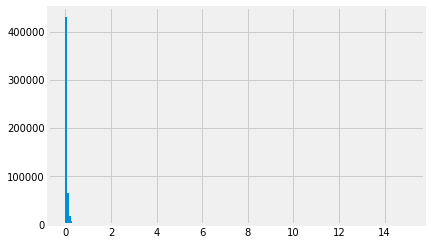

In [149]:
# plot the hist of eucliidian distance, in order to find the outliers
df['euclidian_dist'].hist(bins=200)

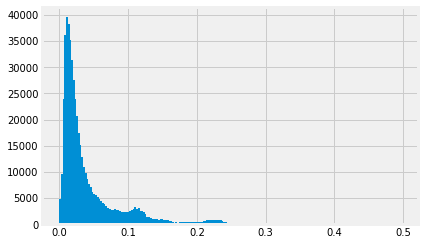

In [150]:
# plot the distribution of euclidian_dist if we control it under 0.5.
df3 = df[df['euclidian_dist']<0.5]
df3['euclidian_dist'].hist(bins=200)

In [151]:
# get the rows number that we will drop under this condition
df[df['euclidian_dist']>0.5]['pickup_longitude'].count()

82

<font color = 'blue'>
   
   
   
__As the histogram indicates, there are a lot of outliers, so we manually select a threshold to remove the outliers__


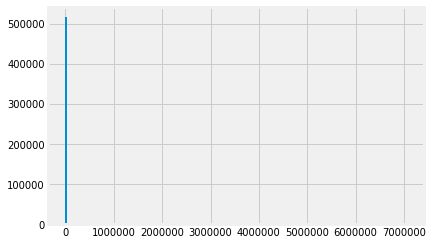

In [152]:
# plot the hist of travel time, in order to find the outliers
df['travel_time'].hist(bins=200)

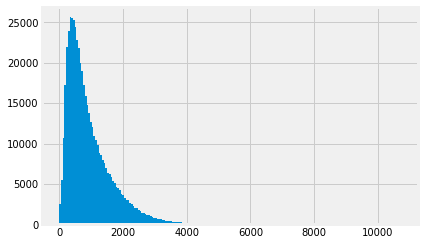

In [153]:
# plot the distribution of travel time if we control it under 3 hours. 
df2 = df[df['travel_time']<10800]
df2['travel_time'].hist(bins=200)

In [154]:
# get the rows number that we will drop under this condition
df[df['travel_time']>10800]['pickup_longitude'].count()

771

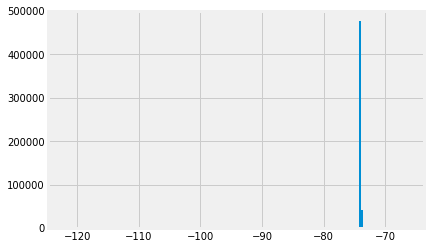

In [155]:
# same as before
df['pickup_longitude'].hist(bins=200)

In [156]:
df[df['pickup_longitude']<-80]['travel_time'].count()

1

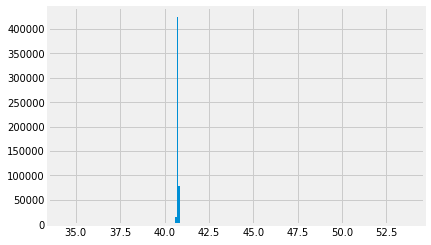

In [157]:
df['pickup_latitude'].hist(bins=200)

In [158]:
df[df['pickup_latitude']<40]['pickup_longitude'].count()

2

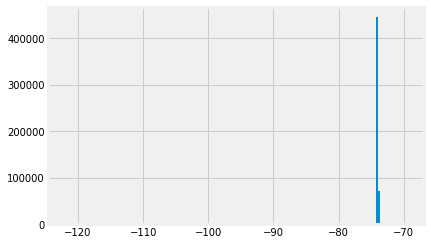

In [159]:
df['dropoff_longitude'].hist(bins=200)

In [160]:
df[df['dropoff_longitude']<-80]['pickup_latitude'].count()

1

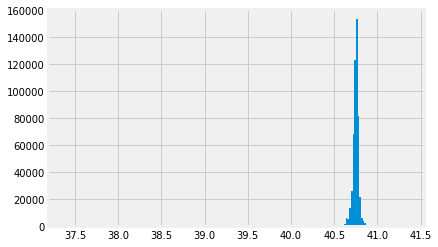

In [161]:
df['dropoff_latitude'].hist(bins=200)

In [162]:
df[df['dropoff_latitude']<40]['pickup_latitude'].count()

2

### Remove outliers

In [7]:
# then we drop the outlier based on histograme we plot before.
df = df[(df['pickup_longitude']>-80) & (df['pickup_latitude']>40) & (df['dropoff_longitude']>-80) & (df['dropoff_latitude']>40)
       & (df['euclidian_dist']<0.5) & (df['travel_time']<10800)] 
# constrain the latitude and longitude to New York city.
df = df[(df['pickup_longitude']>-74.2) & (df['pickup_longitude']<-73.75) & (df['pickup_latitude']>40.6) & (df['pickup_latitude']<40.95) 
        & (df['dropoff_longitude']>-74.2) & (df['dropoff_longitude']<-73.75) & (df['dropoff_latitude']>40.5) & (df['dropoff_latitude']<40.95)
        & (df['travel_time']>0)] 
df.shape

(516361, 44)

<font color = 'blue'>
   
   
   
__Removing all outliers based on our manually selected thresholds__
***

### Pickup Dropoff Location Visualization

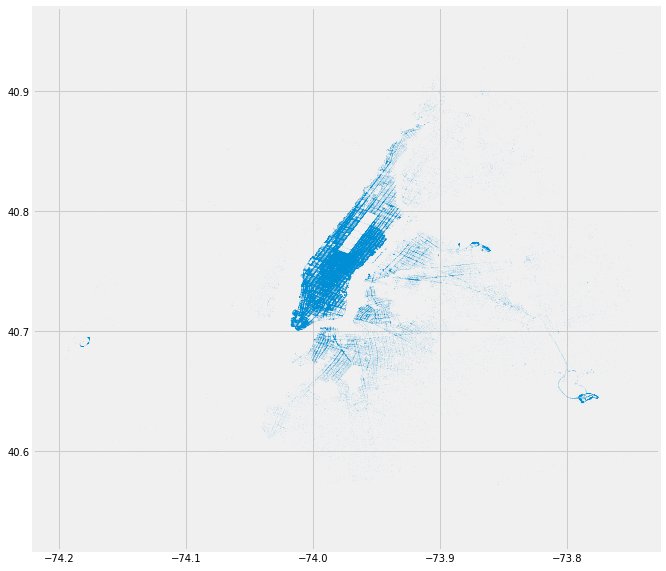

In [165]:
# give the scatter plot of pick up and drop off location. we crop the location only contain New York city. 
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude,latitude,'.', alpha = 0.4, markersize = 0.05)
plt.show()

<font color = 'blue'>
   
   
   
__Most of pickup and dropoff locations are around Mahatten, location in JFK and LGA airport also have high frequency of taxi pick up and drop off__
***

## Exploratory Analysis

Text(0.5, 0.5, 'Day Hour, 0-23')

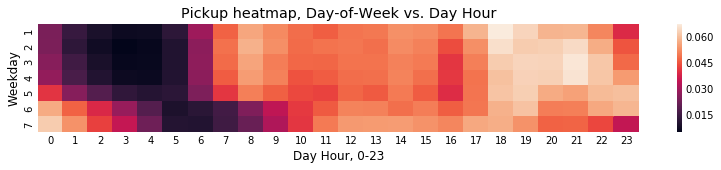

In [148]:
# Pickup heatmap, weekday vs hour
plt.figure(figsize=(12,2))
sns.heatmap(data=pd.crosstab(df.weekday+1, 
                             df.hour_of_day, 
                             values=df.visib, 
                             aggfunc='count',
                             normalize='index'))

plt.title('Pickup heatmap, Day-of-Week vs. Day Hour')
plt.ylabel('Weekday') ; plt.xlabel('Day Hour, 0-23')

<font color = 'blue'>
   
   
   
__We find that week day and day hour have high relationship with pickup frequency. The frequency difference may affect travel time because high frequency always lead to traffic jam__
***

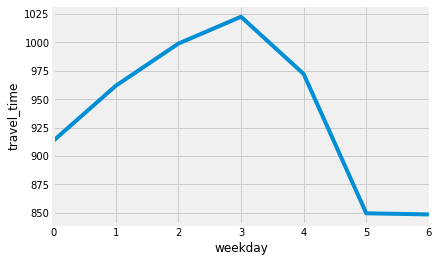

In [217]:
# plot the relationship between travel time and vendor id alone with weekday
start = time.time()
summary_wdays_avg_duration = pd.DataFrame(df.groupby(['weekday'])['travel_time'].mean())
summary_wdays_avg_duration.reset_index(inplace = True)
summary_wdays_avg_duration['unit']=1
sns.tsplot(data=summary_wdays_avg_duration, time="weekday", unit = "unit", value="travel_time")
sns.despine(bottom = False)
end = time.time()

<font color = 'blue'>
   
   
   
__We suspect that weekday can have an effect on travel time. The plot above proves that in specific days, the travel time might be higher. So we want to look further into that in feature selection.__
***

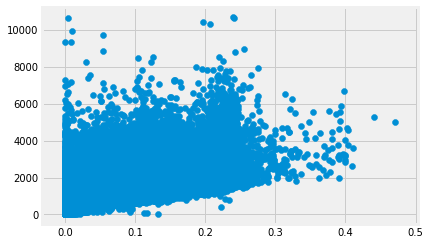

In [164]:
plt.scatter(df['euclidian_dist'],df['travel_time'])

<font color = 'blue'>
   
   
   
__We created a scatter plot of the distance to travel time. We know there should be a relationship, but it's really hard to tell just by looking. But the more important thign here is that it shows our treatment before successfully eliminated significant outliers.__
***

#### Correlation Coefficient for continuous features

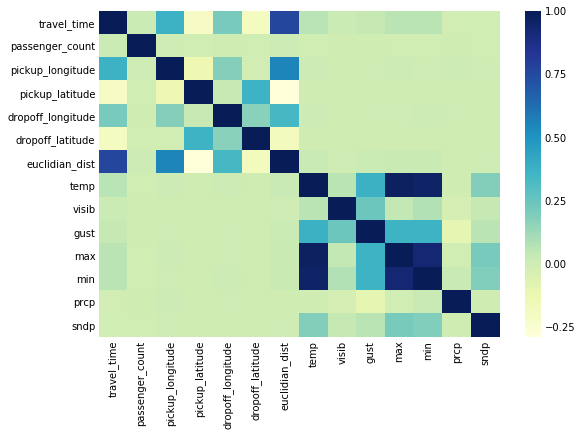

In [166]:
# cut all the continuous features that we may use after to plot correlation coefficient 
df_sort = df[['travel_time','passenger_count',
        'pickup_longitude', 'pickup_latitude', 
        'dropoff_longitude', 'dropoff_latitude',
       'euclidian_dist', 'temp', 'visib', 'gust', 'max', 'min', 'prcp', 'sndp']]
plt.figure(figsize=(8, 6))
vg_corr = df_sort.corr()
sns.heatmap(vg_corr, 
            cmap='YlGnBu')

<font color = 'blue'>
   
   
   
__We plotted the correlation coefficient map. If you look at the first line, we noticed no significant relationship between travel time and passenger count, visib, prcp, sndp. So we will focus on other features.__
***

#### Chi Square examination for category features

In [168]:
# we will use 100000 samples to plot chi square examination
df_sample=df.sample(100000)

In [169]:
# choose the categoric features
df_data=df_sample[['vendor_id','hour_of_day','day_of_year','month_of_year','fog','rain_drizzle','snow_ice_pellets','hail','thunder','weekday']]
df_target=df_sample['travel_time']

In [170]:
# calculate chi square test score
Chi2 = SelectKBest(chi2, k=5)
Chi2.fit_transform(df_data, df_target)

array([[11, 26,  4,  0,  1],
       [14, 29,  5,  0,  6],
       [14,  9,  4,  0,  5],
       ...,
       [ 9,  7,  2,  0,  6],
       [15, 31,  5,  0,  1],
       [11, 10,  5,  0,  1]], dtype=int64)

In [171]:
# plot a table for chi square test score with features.
Chi2_table = pd.DataFrame({'feature': list(df_data.columns), 'Chi square score': list(Chi2.scores_)})
Chi2_table.sort_values(by='Chi square score', ascending=False)

,feature,Chi square score
2,day_of_year,19937.620919
1,hour_of_day,10834.688570
9,weekday,5004.872863
4,fog,3762.772331
3,month_of_year,3723.866555
6,snow_ice_pellets,3304.780786
5,rain_drizzle,2822.090395
0,vendor_id,681.055351
7,hail,NaN
8,thunder,NaN


<font color = 'blue'>
   
   
   
__Using Chi Squared test, we found that vendor_id rain drizzle, and snow ice pellets all have low correlation with travel time. So we will also avoid those features. We also look into hail and thunder features to see why NaN is produced. And we found that all these features are 0. So they are essentially meaningless__
***

In [172]:
df.groupby(['hail']).count()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,euclidian_dist,hour_of_day,date_of_year,day_of_year,month_of_year,year_of_year,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,thunder,weekday
hail,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815


In [173]:
df.groupby(['thunder']).count()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,imp_surcharge,total_amount,travel_time,euclidian_dist,hour_of_day,date_of_year,day_of_year,month_of_year,year_of_year,date_of_year2,year,mo,da,temp,visib,wdsp,gust,max,min,prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,weekday
thunder,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815,515815


## Chosen features 

|Features | Description|Missing values|
|---|---|---|
|pickup_longitude|Longitude for taxi pick up location|NAN|
|pickup_latitude|Latitude for taxi pick up location|NAN|
|dropoff_longitude|Longitude for taxi drop off location|NAN|
|dropoff_latitude|Latitude for taxi drop off location|NAN|
|euclidian_dist|Straight-line distance between two points||
|hour_of_day|Hour of taxi pick up time||
|day_of_year|Day of taxi pick up time||
|weekday|weekday of taxi pick up time||
|gust|Maximum wind gust reported for the day in knots to tenths|999.9|
|max|Maximum temperature reported during the day in Fahrenheit to tenths|9999.9|
|min|Minimum temperature reported during the day in Fahrenheit to tenths|9999.9|

<font color = 'blue'>
   
   
   
__We chose the above 11 features to train our model and make prediction. This decision comes after we run various different models with all the features. And the feature importance table like this one below tells us that above 11 features are the most relevant and useful ones <img src="files/featureimportanceRF.png" width="200">Random Forest<img src="files/featureimportanceXGB.png" width="200"> XGB__
***

#### Cluster  of longitude and latitude and data processing for linear regression model

<font color = 'blue'>
   
   
For linear model, we should transform variables appropriate for it. 

1) The missing value in some weather data are setted as the extrem value. That will perform as outliers in linear model, influence the performance of linear model. So we replace the missing value by mean value.

2) We cannot use longitude and latitude directly into linear model, but the location information have influence to prediction. So we chose kmean function to cluster data, every cluster will have their own label. We use labels to trian linear model instead of longitude and latitude.

3) In linear model, we should get dummy variable for category data, like pickup_label, drop_label, hour_of_day, day_of_year, month_of_year, weekday
***

In [174]:
# choose the features we need for linear regression model
y = df['travel_time']

X_with_label = df[['pickup_longitude', 'pickup_latitude', 
        'dropoff_longitude', 'dropoff_latitude',
       'euclidian_dist', 'hour_of_day', 'day_of_year',
       'weekday',
       'gust', 'max', 'min']]


In [177]:
# for linear model, we replace the missing data with mean of the column. That is because extreme value in linear model 
# may influence the performance of model
X_with_label = X_with_label.replace({'gust': 999.9}, np.mean(X_with_label['gust']))
X_with_label = X_with_label.replace({'max': 9999.9}, np.mean(X_with_label['max']))
X_with_label = X_with_label.replace({'min': 9999.9}, np.mean(X_with_label['min']))

In [178]:
# cluster location by kmean function.
kmeans_pick = KMeans(n_clusters=20, random_state=2, n_init = 10).fit(X_with_label[['pickup_longitude', 'pickup_latitude']])
# create new column to record the label of cluster locations
X_with_label['pickup_label'] = kmeans_pick.labels_

In [179]:
kmeans_drop = KMeans(n_clusters=20, random_state=2, n_init = 10).fit(X_with_label[['dropoff_longitude', 'dropoff_latitude']])
X_with_label['drop_label'] = kmeans_drop.labels_

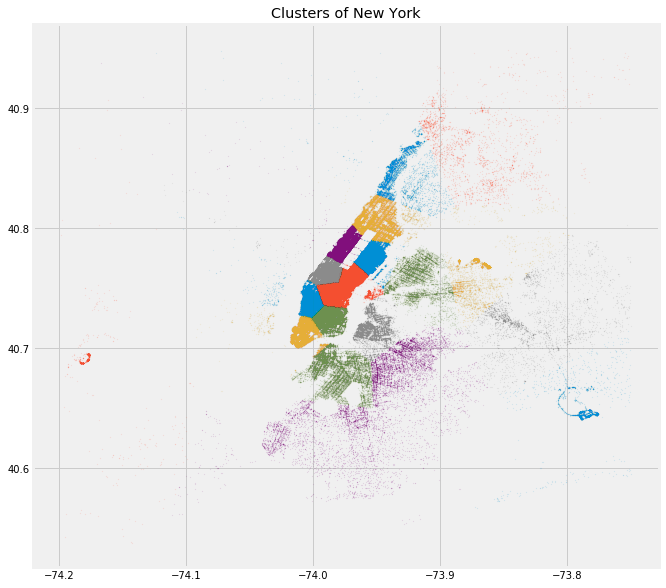

In [180]:
# plot the cluster map
plt.figure(figsize = (10,10))
for label in X_with_label.drop_label.unique():
    plt.plot(X_with_label.dropoff_longitude[X_with_label.drop_label == label],X_with_label.dropoff_latitude[X_with_label.drop_label == label],'.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

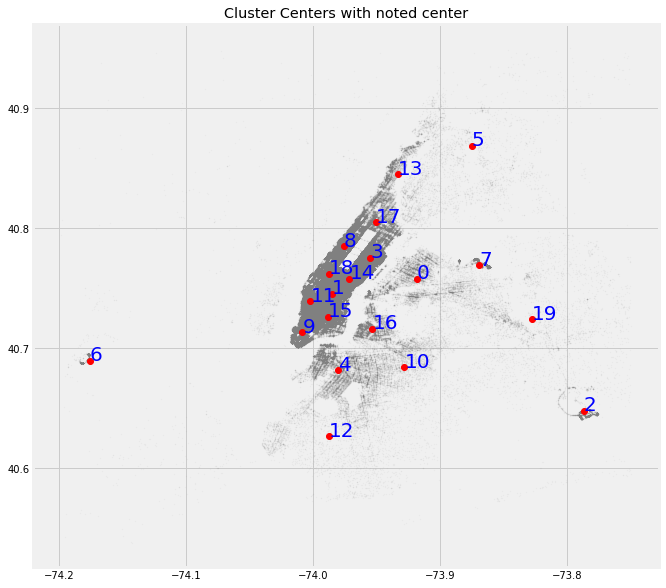

In [182]:
# Plot the center of cluster and corresbonded labels
fig,ax = plt.subplots(figsize = (10,10))
for label in X_with_label.drop_label.unique():
    ax.plot(X_with_label.dropoff_longitude[X_with_label.drop_label == label],X_with_label.dropoff_latitude[X_with_label.drop_label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans_drop.cluster_centers_[label,0],kmeans_drop.cluster_centers_[label,1],'o', color = 'r')
    ax.annotate(label, (kmeans_drop.cluster_centers_[label,0],kmeans_drop.cluster_centers_[label,1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers with noted center')
plt.show()

<font color = 'blue'>
   
   
   
__The above two figures shows our results of the K mean clustering. We are essentially splitting the entire NYC region into 20 neighborhoods so that the label can be used in the linear model__
***

In [183]:
# get dummy variable for category data
print(X_with_label.shape) #pre-dummies shape
X_with_label = pd.get_dummies(data=X_with_label, columns=['pickup_label', 'drop_label', 'hour_of_day', 
                                                   'day_of_year', 'weekday'])
print(X_with_label.shape) #post-dummies shape
X_with_label.head()

(515815, 13)
(515815, 110)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,euclidian_dist,gust,max,min,pickup_label_0,pickup_label_1,pickup_label_2,pickup_label_3,pickup_label_4,pickup_label_5,pickup_label_6,pickup_label_7,pickup_label_8,pickup_label_9,pickup_label_10,pickup_label_11,pickup_label_12,pickup_label_13,pickup_label_14,pickup_label_15,pickup_label_16,pickup_label_17,pickup_label_18,pickup_label_19,drop_label_0,drop_label_1,drop_label_2,drop_label_3,drop_label_4,drop_label_5,drop_label_6,drop_label_7,drop_label_8,drop_label_9,drop_label_10,drop_label_11,drop_label_12,drop_label_13,drop_label_14,drop_label_15,drop_label_16,drop_label_17,drop_label_18,drop_label_19,hour_of_day_0,hour_of_day_1,hour_of_day_2,hour_of_day_3,hour_of_day_4,hour_of_day_5,hour_of_day_6,hour_of_day_7,hour_of_day_8,hour_of_day_9,hour_of_day_10,hour_of_day_11,hour_of_day_12,hour_of_day_13,hour_of_day_14,hour_of_day_15,hour_of_day_16,hour_of_day_17,hour_of_day_18,hour_of_day_19,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,day_of_year_1,day_of_year_2,day_of_year_3,day_of_year_4,day_of_year_5,day_of_year_6,day_of_year_7,day_of_year_8,day_of_year_9,day_of_year_10,day_of_year_11,day_of_year_12,day_of_year_13,day_of_year_14,day_of_year_15,day_of_year_16,day_of_year_17,day_of_year_18,day_of_year_19,day_of_year_20,day_of_year_21,day_of_year_22,day_of_year_23,day_of_year_24,day_of_year_25,day_of_year_26,day_of_year_27,day_of_year_28,day_of_year_29,day_of_year_30,day_of_year_31,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,-73.952690,40.776501,-73.956306,40.771549,0.006131,21.0,55.9,48.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-73.998581,40.744957,-73.965797,40.766151,0.039038,31.1,62.1,39.9,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,-73.989426,40.741684,-73.966812,40.803967,0.066261,35.9,62.1,42.1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
6,-74.002602,40.724880,-73.997505,40.721855,0.005927,28.9,39.9,30.9,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
8,-73.982346,40.778442,-73.987534,40.757046,0.022017,31.1,55.9,35.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [184]:
# develope the features for linear model. Use location label instead of latitude and longitude
X_with_label = X_with_label.drop(X_with_label[['pickup_longitude','dropoff_longitude','pickup_latitude','dropoff_latitude']],axis=1)

In [185]:
print(X_with_label.shape)
X_with_label.columns

(515815, 106)


Index(['euclidian_dist', 'gust', 'max', 'min', 'pickup_label_0',
       'pickup_label_1', 'pickup_label_2', 'pickup_label_3', 'pickup_label_4',
       'pickup_label_5',
       ...
       'day_of_year_29', 'day_of_year_30', 'day_of_year_31', 'weekday_0',
       'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5',
       'weekday_6'],
      dtype='object', length=106)

<font color = 'blue'>
   
   
   
__Dummy variables for the categorical data were also created. This is so that the data can be entered into the linear model__
***

# Build models

We choose linear model and compare with other regression model to find the best performance one

### Features for linear regression model

Here we use both $ L^1 $ and $ L^2 $ to compare with linear regression model. That is because we have so many features, 112 features. We try to use Lasso and Ridge to cut down features and get better model performance.

In [208]:
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(X_with_label, y, test_size=0.2, random_state=42)
print(X_train_l.shape)

(412652, 106)


#### Linear regression: without / lasso / ridge regularization

##### Linear Regression without regulation

In [189]:
# This cell define the function that we will use in linear regression model, same as L1 and L2.
# this function is to trian model, print error score
def cross_validate_result_linear(model_linear):
    # trian model by input model, using 5 fold cross valitation function
    cv_results_linear=cross_validate(model_linear, X_with_label, y, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_estimator =True)
    # this loop is trying to get feature coefficent in every fold
    cv_coef_linear = []
    for model in cv_results_linear['estimator']:
        cv_coef_linear.append(model.coef_)
    cv_coef_linear = np.array(cv_coef_linear)
    # print r2 score and rmse by average the scores get from every fold
    print('The r^2 score of test data is:',cv_results_linear['test_r2'].mean()) 
    print('The rmse of test data is:',np.sqrt(abs(cv_results_linear['test_neg_mean_squared_error'].mean())))
    return cv_coef_linear, cv_results_linear['test_r2'].mean(), np.sqrt(abs(cv_results_linear['test_neg_mean_squared_error'].mean()))

# this function will plot feature importance of model 
def find_feature_importance_linear(model_linear):
    coef_linear, r2, mse = cross_validate_result_linear(model_linear)
    # create a table to plot features coefficient by average the coefficients get from every fold
    impor_linear = pd.DataFrame({'feature': list(X_with_label.columns), 'feature importance': list(np.mean(coef_linear, axis=0))})
    return impor_linear.sort_values(by='feature importance', ascending=False), r2, mse

# this function will plot the features that have low importance.
def find_low_importance_feature_linear(impor_linear, constrain):
    # constrain the feature coefficient to a small range to sort features.
    impor_lr2 = impor_linear[(impor_linear['feature importance']<constrain) & (impor_linear['feature importance']>-constrain) ]
    return impor_lr2.sort_values(by='feature importance', ascending=False)

In [190]:
# use function before to plot r2 score, rmse, and feature coefficients
clf = linear_model.LinearRegression(fit_intercept = True, normalize=True)#
import_linear_table, r2_linear, mse_linear=find_feature_importance_linear(clf)
import_linear_table

The r^2 score of test data is: 0.6594405757870282
The rmse of test data is: 427.3333920340258


,feature,feature importance
102,weekday_3,7.732076e+13
101,weekday_2,7.732076e+13
103,weekday_4,7.732076e+13
100,weekday_1,7.732076e+13
104,weekday_5,7.732076e+13
99,weekday_0,7.732076e+13
105,weekday_6,7.732076e+13
0,euclidian_dist,1.498151e+04
3,min,1.838053e+00
2,max,2.388288e-01


In [192]:
find_low_importance_feature_linear(import_linear_table, 100)

,feature,feature importance
3,min,1.838053
2,max,0.238829
1,gust,0.078651


<font color = 'blue'>
   
   
   
__The first model is linear regression, we obtained an r2 score of 0.66. We did not normalize the data before hand. However, we used the methods within the linearregression obtain to normalize our data__
***

##### Lasso

In [193]:
linear_model = Lasso(fit_intercept = True ,normalize=True)

params = {
    "alpha": np.arange(0.01,0.5,0.01)
}

search = RandomizedSearchCV(linear_model, param_distributions=params, random_state=0, n_iter=10, cv=5, verbose=1, 
                            n_jobs=-1, return_train_score=True)
search.fit(X_train_l,y_train_l)
search.best_params_


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   38.2s finished


{'alpha': 0.05}

In [194]:
search.best_estimator_

Lasso(alpha=0.05, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [195]:
lasso = Lasso(alpha=0.05, fit_intercept = True ,normalize=True) 
# result_lasso = linear_model.LinearRegression(fit_intercept = True, normalize=True)#
import_lasso_table, r2_lasso, mse_lasso=find_feature_importance_linear(lasso)
import_lasso_table

The r^2 score of test data is: 0.5920771655442445
The rmse of test data is: 467.73793280839806


,feature,feature importance
0,euclidian_dist,11388.784811
28,drop_label_4,24.286693
59,hour_of_day_15,14.042118
102,weekday_3,0.597356
60,hour_of_day_16,0.229186
3,min,0.135298
69,day_of_year_2,0.000000
78,day_of_year_11,0.000000
77,day_of_year_10,0.000000
76,day_of_year_9,0.000000


In [198]:
find_low_importance_feature_linear(import_lasso_table, 1)

,feature,feature importance
102,weekday_3,0.597356
60,hour_of_day_16,0.229186
3,min,0.135298
31,drop_label_7,0.000000
6,pickup_label_2,0.000000
7,pickup_label_3,0.000000
8,pickup_label_4,0.000000
9,pickup_label_5,0.000000
10,pickup_label_6,0.000000
11,pickup_label_7,0.000000


<font color = 'blue'>
   
   
   
__We noticed that Lasso regularization eliminates many of the features. The r2 score is 0.59. So we think there is a over - elimination of features as the feature importance table only display 3 features__
***

##### Ridge

In [209]:
# use RidgeCV function to find the best value for alpha, use it into Ridge model
rcv = RidgeCV()
rcv.fit(X_train_l,y_train_l)
ridge = Ridge(alpha=rcv.alpha_, fit_intercept = True ,normalize=True)


import_ridge_table, r2_ridge, mse_ridge=find_feature_importance_linear(ridge)
import_ridge_table

The r^2 score of test data is: 0.6424549685059043
The rmse of test data is: 437.9038231343537


,feature,feature importance
0,euclidian_dist,11289.666909
34,drop_label_10,331.099216
28,drop_label_4,245.604955
40,drop_label_16,209.113098
59,hour_of_day_15,159.009246
60,hour_of_day_16,153.288698
61,hour_of_day_17,136.983574
58,hour_of_day_14,128.312380
36,drop_label_12,110.149297
24,drop_label_0,108.792521


In [210]:
find_low_importance_feature_linear(import_ridge_table, 5)

,feature,feature importance
71,day_of_year_4,4.671617
38,drop_label_14,4.426312
89,day_of_year_22,3.524890
83,day_of_year_16,3.033658
94,day_of_year_27,2.864874
3,min,1.342487
78,day_of_year_11,1.272055
70,day_of_year_3,0.935031
11,pickup_label_7,0.644028
2,max,0.632814


<font color = 'blue'>
   
   
   
__Ridge r2 score is around 0.64. Which is also lower than linear regression. Lasso eliminates too many features, while Ridge saves features and recognize that euclidian distance is the most important features. At the end, we decided that linear model is the best one. Because regularization is for cases where there is limited data, and when there are a lot of features. So we don't think this is applicable to our case. This is why regularized models perform worse than linear models__
***

### Features for other regression models

<font color = 'blue'>
   
   
For other regression models:
1) We do not need to deal with missing valus in weather dataset, because they can processe extrem value.
2) We do not need to modify the pickup and dropoff longitude and latitute values.
3) We do not need dummy variables


***

In [9]:
y = df['travel_time']

X = df[['pickup_longitude', 'pickup_latitude', 
        'dropoff_longitude', 'dropoff_latitude',
       'euclidian_dist', 'hour_of_day', 'day_of_year',
       'weekday',
       'gust', 'max', 'min']]

print(X.shape) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X.head()

(516361, 11)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,euclidian_dist,hour_of_day,day_of_year,weekday,gust,max,min
2,-73.977608,40.763653,-73.962196,40.770412,0.016829,10,8,4,999.9,44.6,35.6
7,-73.954338,40.730339,-73.926399,40.727470,0.028086,4,15,0,999.9,30.2,14.0
8,-73.981857,40.768581,-73.966331,40.794449,0.030169,10,14,5,999.9,71.6,56.3
10,-73.984596,40.764851,-73.979668,40.776138,0.012317,23,15,6,999.9,60.8,50.0
11,-73.968407,40.799671,-73.956146,40.779572,0.023544,18,17,1,999.9,64.4,55.4


#### Define function for train other models, get r2 socre, rmse and feature importances

In [41]:
def cross_validate_result_other(model_other):
    cv_results_other=cross_validate(model_other, X, y, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_estimator =True)
    cv_coef_other = []
    for model in cv_results_other['estimator']:
        # use feature importance instead of coefficent as before
        cv_coef_other.append(model.feature_importances_)
    cv_coef_other = np.array(cv_coef_other)
    print('Cross validate score of test is',cv_results_other['test_r2'].mean()) 
    print('Cross validate rmse of test is',np.sqrt(abs(cv_results_other['test_neg_mean_squared_error'].mean())))
    return cv_coef_other, cv_results_other['test_r2'].mean(), np.sqrt(abs(cv_results_other['test_neg_mean_squared_error'].mean()))
def find_feature_importance_other(model_other):
    coef_other, r2, mse= cross_validate_result_other(model_other)
    impor_other = pd.DataFrame({'feature': list(X.columns), 'feature importance': list(np.mean(coef_other, axis=0))})
    return impor_other.sort_values(by='feature importance', ascending=False), r2, mse

In [38]:
def plot_feature_importance(feature_importances_):
    impor_other = pd.DataFrame({'feature': list(X.columns), 'feature importance': list(feature_importances_)})
    return impor_other.sort_values(by='feature importance', ascending=False)

## Decision tree

In [204]:
# set parameter range for Gridsearch CV function to find the best parameters
max_depth = range(1,10,1)
min_samples_leaf = range(1,10,2)
tuned_parameters = dict(max_depth=max_depth, min_samples_leaf=min_samples_leaf)

In [205]:
# Use gridsearch cv function to find the best parameters, print out best parameters.
scoring = {'r2', 'neg_mean_squared_error'}
dt = GridSearchCV(DecisionTreeRegressor(), tuned_parameters,cv=5, scoring=scoring,refit='neg_mean_squared_error')
dt.fit(X, y)
dt_best_params=dt.best_params_
dt_best_cross_val_score = (np.sqrt(-dt.best_score_))
r2_dt = dt.cv_results_['mean_test_r2'][dt.best_index_]
mse_dt = dt_best_cross_val_score
print("Best cross validation rmse score: %f using parameters %s" % (mse_dt, dt_best_params))
print('r2 score for cross validation:',r2_dt )

Best cross validation rmse score: 379.603567 using parameters {'max_depth': 9, 'min_samples_leaf': 9}
r2 score for cross validation: 0.7312426908540299


In [206]:
plot_feature_importance(dt.best_estimator_.feature_importances_)

,feature,feature importance
4,euclidian_dist,0.858682
5,hour_of_day,0.078347
7,weekday,0.024046
3,dropoff_latitude,0.017926
0,pickup_longitude,0.008084
2,dropoff_longitude,0.006029
10,min,0.004051
1,pickup_latitude,0.002674
8,gust,0.000110
9,max,0.000044


<font color = 'blue'>
   
   
   
__Using decision tree, we obtained a r2 score of 0.73. Which is higher than any of the linear models. The feature importance table tells us that the distance is perhaps the most important feature__
***

## Random forest regression

In [ ]:
# gridsearch cv function to find the best parameter for random forest regression
from sklearn.ensemble import RandomForestRegressor
import numpy as np
scoring = {'r2', 'neg_mean_squared_error'}
param_grid_rf = [{'n_estimators': [10, 30, 50, 70,90,110], 'max_features': [0.4,0.6,0.8,1.0], 'max_depth': [ 9,11,13,15,17,19,21]}]
from sklearn.ensemble import RandomForestRegressor # import RandomForestRegressor
from sklearn.model_selection import GridSearchCV  # import GridSearchCV to find the best parameter
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring=scoring,refit='neg_mean_squared_error') # set parameter for grid search
grid_search_rf.fit(X,y) # train model
rf_best_params=grid_search_rf.best_params_
rf_best_cross_val_score = (np.sqrt(-grid_search_rf.best_score_))
#best_cv_score=np.expm1(rf_best_cross_val_score)

In [ ]:
r2_rf = grid_search_rf.cv_results_['mean_test_r2'][grid_search_rf.best_index_]
mse_rf = rf_best_cross_val_score

In [216]:
print('Best cross validation rmse score:',mse_rf)
print('r2 score for cross validation:',r2_rf)

Best cross validation rmse score: 342.3421812131083
r2 score for cross validation: 0.7814570267686148


In [215]:
rf = RandomForestRegressor(n_estimators=30,min_samples_leaf=10, min_samples_split=15, max_depth=21,verbose=0,max_features=1.0,bootstrap=True,n_jobs=-1)

impor_rf, r2_rf, mse_rf = find_feature_importance_other(rf)
impor_rf

Cross validate score of test is 0.7814570267686148
Cross validate rmse of test is 342.3421812131083


,feature,feature importance
4,euclidian_dist,0.758102
5,hour_of_day,0.078490
3,dropoff_latitude,0.035125
7,weekday,0.027759
2,dropoff_longitude,0.025164
0,pickup_longitude,0.024445
1,pickup_latitude,0.018788
10,min,0.012589
6,day_of_year,0.007256
9,max,0.007108


<font color = 'blue'>
   
   
   
__Random forest gives us a r2 score os 0.78. The feature importance plot again confirmed that distance is the most important feature, followed by hour of day, and pickup dropoff locations__
***

## Kneighbors regressor

In [219]:
knn = KNeighborsRegressor(n_neighbors=10)
results_knn=cross_validate(knn, X, y, cv=5, scoring=('r2', 'neg_mean_squared_error'), return_estimator =True)

r2_knn = results_knn['test_r2'].mean()
mse_knn = np.sqrt(abs(results_knn['test_neg_mean_squared_error'].mean()))

print('Cross validate score of knn is',r2_knn) 
print('Cross validate rmse of knn is',mse_knn)

Cross validate score of knn is 0.5241023037718182
Cross validate rmse of knn is 505.2213739985629


## XGBoost

#### Use gridsearch cv function to find the best parameters for XGBoost model

In [11]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

xgb = XGBRegressor()
# Set parametes for XGBoost
params = {
    "colsample_bytree": [0.9],
    "gamma": [0.25],
    "learning_rate": [0.05, 0.1, 0.15, 0.3], # default 0.1 
    "max_depth": [7,8, 9,10,11], # default 3
    "n_estimators": [100, 120, 130, 140], # default 100
    "subsample": [0.99] }

scoring = {'r2', 'neg_mean_squared_error'}

xgb_grid = GridSearchCV(xgb,
                        params,
                        cv = 5,
                        n_jobs = 5,
                        verbose=True, scoring=scoring,refit='neg_mean_squared_error')
# use best parameters get from gridsearch CV to fit x and y
xgb_grid.fit(X, y)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed: 39.6min
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed: 264.2min
[Parallel(n_jobs=5)]: Done 400 out of 400 | elapsed: 573.5min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=5,
       param_grid={'colsample_bytree': [0.9], 'gamma': [0.25], 'learning_rate': [0.05, 0.1, 0.15, 0.3], 'max_depth': [7, 8, 9, 10, 11], 'n_estimators': [100, 120, 130, 140], 'subsample': [0.99]},
       pre_dispatch='2*n_jobs', refit='neg_mean_squared_error',
       return_train_score='warn', scoring={'r2', 'neg_mean_squared_error'},
       verbose=True)

In [17]:
# save the model
pkl_filename = "xgb_grid2.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(xgb_grid, file)

In [16]:
xgb_best_params_grid=xgb_grid.best_params_
xgb_best_cross_val_score_grid = (np.sqrt(-xgb_grid.best_score_))
r2_xgb_grid = xgb_grid.cv_results_['mean_test_r2'][xgb_grid.best_index_]
mse_xgb_grid = xgb_best_cross_val_score_grid
print("Best cross validation rmse score: %f using parameters %s" % (mse_xgb_grid, xgb_best_params_grid))
print('r2 score for cross validation:',r2_xgb_grid )

Best cross validation rmse score: 331.341910 using parameters {'colsample_bytree': 0.9, 'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 140, 'subsample': 0.99}
r2 score for cross validation: 0.7948412616999592


In [39]:
plot_feature_importance(xgb_grid.best_estimator_.feature_importances_)

,feature,feature importance
4,euclidian_dist,0.529548
5,hour_of_day,0.111443
7,weekday,0.083277
0,pickup_longitude,0.056348
2,dropoff_longitude,0.052220
3,dropoff_latitude,0.051888
1,pickup_latitude,0.034576
10,min,0.032057
9,max,0.016617
8,gust,0.016144


<font color = 'blue'>
   
   
   
__XGboost has the best r2 score at 0.79. Its feature importance also confirmed the importance of distance. However, it also place emphasis on hour_of_day, which makes sense because when you get the taxi throughout the day can affect the time, as we discussed above in the heatmap__
***

## Compare different models performance

|model|cross validate r2 socre|cross validate rmse|
|---|---|---|
|linear regression|	0.659441|	427.333392|
|lasso	|0.592077|	467.737933|
|ridge	|0.642455|	437.903823|
|decision tree regession|	0.731243|	379.603567|
|random forest regression|	0.781457|	342.342181|
|k nearest neighbor|	0.524102|	505.221374|
|XGBoost|	0.794841|	331.341910|

<font color='blue'>
    
__Above is the table showing all our results of the different models that we used. We found that XGBoost, decision, and random forest have better results than other. And we chose XGBoost as our final model__
***

## Analysis test dataset

In [27]:
# import weather dataset in 2015 from big query 
query = (
    """
    SELECT * 
    FROM `bigquery-public-data.noaa_gsod.gsod2015` where stn='725053'
    LIMIT 1000000"""
)
df_weather1=pd.io.gbq.read_gbq(query,dialect='standard')


In [28]:
df_weather = df_weather1
# import test dataset
df_test=pd.read_csv('APM4990_final_test_data_filtered.csv')
print(df_weather.shape)
df_weather.head()

(365, 32)


,stn,wban,year,mo,da,temp,count_temp,dewp,count_dewp,slp,count_slp,stp,count_stp,visib,count_visib,wdsp,count_wdsp,mxpsd,gust,max,flag_max,min,flag_min,prcp,flag_prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud
0,725053,94728,2015,03,10,47.2,24,30.1,24,1024.6,21,1019.0,24,8.5,24,3.3,24,7.0,14.0,54.0,None,39.0,None,0.13,A,13.0,0,1,0,0,0,0
1,725053,94728,2015,12,31,46.5,7,42.7,7,9999.9,0,1013.7,7,5.4,7,3.0,7,6.0,999.9,48.0,*,45.0,*,0.19,G,999.9,0,1,0,0,0,0
2,725053,94728,2015,11,30,39.4,23,27.8,23,1028.4,5,1023.4,5,999.9,0,6.0,5,8.9,999.9,44.6,*,33.8,*,0.00,G,999.9,0,0,0,0,0,0
3,725053,94728,2015,01,07,20.7,24,5.7,24,1015.9,24,1010.8,24,9.7,24,9.5,21,15.9,29.9,23.0,None,15.1,None,0.05,G,999.9,0,0,0,0,0,0
4,725053,94728,2015,01,15,29.5,24,16.3,24,1019.8,24,1014.8,24,10.0,24,3.6,22,8.0,999.9,34.0,*,25.0,*,0.00,G,999.9,0,0,0,0,0,0


In [29]:
# extract date information from pickup_datetime features
df_test['datetime']=pd.to_datetime(df_test['pickup_datetime'])
df_test['date_of_year']=df_test['datetime'].dt.date
df_test['date_of_year2']=[str(day) for day in df_test['date_of_year']]
df_test['hour_of_day']=df_test['datetime'].dt.hour
df_test['day_of_year']=df_test['datetime'].dt.day
df_test['weekday']=df_test['datetime'].dt.weekday

# define function to calculate euclidian_dist
def e_dist(lat1,lon1,lat2,lon2):
    e_dist=np.sqrt(pow((lon1- lon2),2) + pow((lat1 -lat2), 2))
    return e_dist

# create new column to store euclidian_dist
df_test['euclidian_dist']=df_test.apply(lambda row: e_dist(row['pickup_latitude'], row['pickup_longitude'],row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

df_weather.loc[:,['year']] = pd.to_numeric(df_weather['year'])
df_weather.loc[:,['mo']] = pd.to_numeric(df_weather['mo'])
df_weather.loc[:,['da']] = pd.to_numeric(df_weather['da'])

# define function to get date time from weather dataset
def to_datetime(year,mo,da):
    datetime=pd.datetime(year,mo,da)
    return datetime
df_weather['date2']=df_weather.apply(lambda row: to_datetime(row['year'], row['mo'],row['da']), axis=1)
df_weather['date2_string'] = df_weather['date2'].dt.strftime('%Y-%m-%d')

In [30]:
df_test['date_of_year2'].nunique()

365

In [31]:
df_weather['date2_string'].nunique()

365

In [32]:
# merge two table
df_test_final = df_test.merge(df_weather,how = 'left',left_on='date_of_year2',right_on='date2_string')

print(df_test_final.shape)
df_test_final.head()

(694047, 47)


,pickup_datetime,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,passenger_count,datetime,date_of_year,date_of_year2,hour_of_day,day_of_year,weekday,euclidian_dist,stn,wban,year,mo,da,temp,count_temp,dewp,count_dewp,slp,count_slp,stp,count_stp,visib,count_visib,wdsp,count_wdsp,mxpsd,gust,max,flag_max,min,flag_min,prcp,flag_prcp,sndp,fog,rain_drizzle,snow_ice_pellets,hail,thunder,tornado_funnel_cloud,date2,date2_string
0,2015-06-18 21:52:45+00:00,40.702740,-74.011650,40.773361,-73.990311,5,2015-06-18 21:52:45+00:00,2015-06-18,2015-06-18,21,18,3,0.073775,725053,94728,2015,6,18,66.8,24,58.2,24,1018.3,21,1013.6,24,9.8,24,3.3,20,7.0,999.9,71.1,None,64.0,None,0.00,G,999.9,0,0,0,0,0,0,2015-06-18,2015-06-18
1,2015-11-08 02:22:25+00:00,40.733608,-74.003098,40.836803,-73.941643,1,2015-11-08 02:22:25+00:00,2015-11-08,2015-11-08,2,8,6,0.120108,725053,94728,2015,11,8,51.9,24,31.1,24,1025.2,24,1020.3,24,10.0,24,4.0,22,13.0,19.0,55.9,*,46.0,*,0.00,G,999.9,0,0,0,0,0,0,2015-11-08,2015-11-08
2,2015-02-13 04:11:11+00:00,40.730911,-74.001442,40.665699,-73.956909,1,2015-02-13 04:11:11+00:00,2015-02-13,2015-02-13,4,13,4,0.078967,725053,94728,2015,2,13,16.1,24,-4.7,24,1017.2,24,1012.1,24,10.0,24,8.8,24,15.9,28.0,39.9,None,8.1,None,0.00,G,7.9,0,0,0,0,0,0,2015-02-13,2015-02-13
3,2015-07-23 09:14:04+00:00,40.774078,-73.874550,40.749939,-73.991203,2,2015-07-23 09:14:04+00:00,2015-07-23,2015-07-23,9,23,3,0.119125,725053,94728,2015,7,23,76.7,24,49.0,24,1012.3,23,1007.6,24,10.0,24,4.1,20,7.0,14.0,86.0,None,68.0,None,0.00,G,999.9,0,0,0,0,0,0,2015-07-23,2015-07-23
4,2015-01-07 18:06:43+00:00,40.791588,-73.964874,40.792084,-73.968254,2,2015-01-07 18:06:43+00:00,2015-01-07,2015-01-07,18,7,2,0.003416,725053,94728,2015,1,7,20.7,24,5.7,24,1015.9,24,1010.8,24,9.7,24,9.5,21,15.9,29.9,23.0,None,15.1,None,0.05,G,999.9,0,0,0,0,0,0,2015-01-07,2015-01-07


### Use model to predict the trip duration

In [33]:

# prepare X from tes dataset to predict 
X_test = df_test_final[['pickup_longitude', 'pickup_latitude', 
        'dropoff_longitude', 'dropoff_latitude',
       'euclidian_dist', 'hour_of_day', 'day_of_year',
       'weekday',
       'gust', 'max', 'min']]
print(X_test.shape)
X_test.head()

(694047, 11)
(694047, 11)


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,euclidian_dist,hour_of_day,day_of_year,weekday,gust,max,min
0,-74.011650,40.702740,-73.990311,40.773361,0.073775,21,18,3,999.9,71.1,64.0
1,-74.003098,40.733608,-73.941643,40.836803,0.120108,2,8,6,19.0,55.9,46.0
2,-74.001442,40.730911,-73.956909,40.665699,0.078967,4,13,4,28.0,39.9,8.1
3,-73.874550,40.774078,-73.991203,40.749939,0.119125,9,23,3,14.0,86.0,68.0
4,-73.964874,40.791588,-73.968254,40.792084,0.003416,18,7,2,29.9,23.0,15.1


In [34]:
# use gridsearch XGBoost model to predict travel time
y_test_xgb = xgb_grid.predict(X_test)
y_test_xgb

array([1470.7335 , 1553.05   , 1306.701  , ..., 1400.3212 ,  408.45087,
       1222.8369 ], dtype=float32)

In [35]:
# creat a table that contains the features we use, and predict travel time
test_final =  X_test
test_final['predict_travel_time'] = y_test_xgb
test_final.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,euclidian_dist,hour_of_day,day_of_year,weekday,gust,max,min,predict_travel_time
0,-74.011650,40.702740,-73.990311,40.773361,0.073775,21,18,3,999.9,71.1,64.0,1470.733521
1,-74.003098,40.733608,-73.941643,40.836803,0.120108,2,8,6,19.0,55.9,46.0,1553.050049
2,-74.001442,40.730911,-73.956909,40.665699,0.078967,4,13,4,28.0,39.9,8.1,1306.701050
3,-73.874550,40.774078,-73.991203,40.749939,0.119125,9,23,3,14.0,86.0,68.0,2506.528564
4,-73.964874,40.791588,-73.968254,40.792084,0.003416,18,7,2,29.9,23.0,15.1,160.708313


In [36]:
# save table as csv file
test_final.to_csv('test_prediction_xgbgrid.csv')